In [ ]:
# Import Libraries and Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import Libraries
import shutil
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
import cv2
import albumentations as A
from tensorflow.keras.utils import to_categorical
import time

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

Mounted at /content/drive


In [ ]:
# Load Data
# Paths to datasets in Google Drive
data_path = '/content/drive/MyDrive/Released_Data_NNDL_2025/train_images'
csv_path = '/content/drive/MyDrive/Released_Data_NNDL_2025/train_data.csv'
subclass_map_path = '/content/drive/MyDrive/Released_Data_NNDL_2025/subclass_mapping.csv'

# Local path in Colab for faster I/O
local_data_path = '/content/train_images'

# Copy train_images to local disk for faster access
if not os.path.exists(local_data_path):
    print("Copying train_images to local disk for faster processing...")
    shutil.copytree(data_path, local_data_path)
else:
    print("train_images already exists on local disk, skipping copy...")

# Load the CSV file
df = pd.read_csv(csv_path)

# Filter for dogs (superclass_index == 1)
dog_df = df[df['superclass_index'] == 1].reset_index(drop=True)

# Verify the number of classes (should be 30 unique subclasses: 0-85 + 87)
num_classes = dog_df['subclass_index'].nunique()
print(f"Number of dog breeds: {num_classes}")

# Display sample data
dog_df.tail()

Copying train_images to local disk for faster processing...
Number of dog breeds: 30


,image,superclass_index,subclass_index,description
3171,n02107574_750.jpg,1,87,"nature photograph of a dog, specifically a nov..."
3172,n02107574_2386.jpg,1,87,"nature photograph of a dog, specifically a nov..."
3173,n02107574_2436.jpg,1,87,"nature photograph of a dog, specifically a nov..."
3174,n02107574_1953.jpg,1,87,"nature photograph of a dog, specifically a nov..."
3175,n02107574_656.jpg,1,87,"nature photograph of a dog, specifically a nov..."


In [ ]:
# Encode Labels and Split Data
# Encode subclass labels
label_encoder = LabelEncoder()
dog_df['subclass_encoded'] = label_encoder.fit_transform(dog_df['subclass_index'])

# Split into train and validation (80-20 split)
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(dog_df, test_size=0.2, stratify=dog_df['subclass_encoded'], random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

Training samples: 2540
Validation samples: 636


In [ ]:
# Data Augmentation and Generator
def augment_image(image):
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.RandomGamma(p=0.2),
        A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2)
    ])
    augmented = transform(image=image)['image']
    return augmented

# Function to load and preprocess image with error handling
def load_image(img_path, target_size=(299, 299)):
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return None
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image: {img_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    return img

# Generator function for training with error handling
def data_generator(df, img_dir, batch_size=32, augment=True, target_size=(299, 299)):
    while True:
        df = df.sample(frac=1).reset_index(drop=True)  # Shuffle
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_df = df[start:end]

            images = []
            labels = []

            for _, row in batch_df.iterrows():
                img_path = os.path.join(img_dir, row['image'])
                img = load_image(img_path, target_size)

                if img is None:  # Skip if image failed to load
                    continue

                if augment:
                    img = augment_image(img)

                img = img / 255.0  # Normalize
                images.append(img)
                labels.append(row['subclass_encoded'])

            if len(images) == 0:  # Skip empty batches
                continue

            yield np.array(images), to_categorical(labels, num_classes=num_classes)

In [ ]:
# Build Model
def build_model(num_classes):
    # Load pre-trained InceptionV3
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

    # Freeze base model layers
    base_model.trainable = False

    # Add custom layers
    inputs = Input(shape=(299, 299, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Build and summarize model
model = build_model(num_classes)
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,395,774 (211.32 MB)

 Trainable params: 33,592,222 (128.14 MB)

 Non-trainable params: 21,803,552 (83.17 MB)

In [ ]:
# Train Model
# Define batch size and steps
batch_size = 32
train_steps = len(train_df) // batch_size
val_steps = len(val_df) // batch_size

# Create data generators
train_gen = data_generator(train_df, local_data_path, batch_size=batch_size, augment=True)
val_gen = data_generator(val_df, local_data_path, batch_size=batch_size, augment=False)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

<ipython-input-4-64c3e2ec93bf>:8: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2)


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - accuracy: 0.5697 - loss: 1.5218 - val_accuracy: 0.8257 - val_loss: 0.5239 - learning_rate: 0.0010
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - accuracy: 0.6604 - loss: 1.1506 - val_accuracy: 0.8799 - val_loss: 0.3614 - learning_rate: 0.0010
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - accuracy: 0.7193 - loss: 0.9204 - val_accuracy: 0.8914 - val_loss: 0.3386 - learning_rate: 0.0010
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 239ms/step - accuracy: 0.7592 - loss: 0.7986 - val_accuracy: 0.9205 - val_loss: 0.2519 - learning_rate: 0.0010
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - accuracy: 0.8024 - loss: 0.6054 - val_accuracy: 0.9243 - val_loss: 0.2197 - learning_rate: 0.0010
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.8354 - loss: 0.5338 - val_accuracy: 0.9255 - val_loss: 0.2673 - learning_rate: 0.0010
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.8566 - loss: 0.

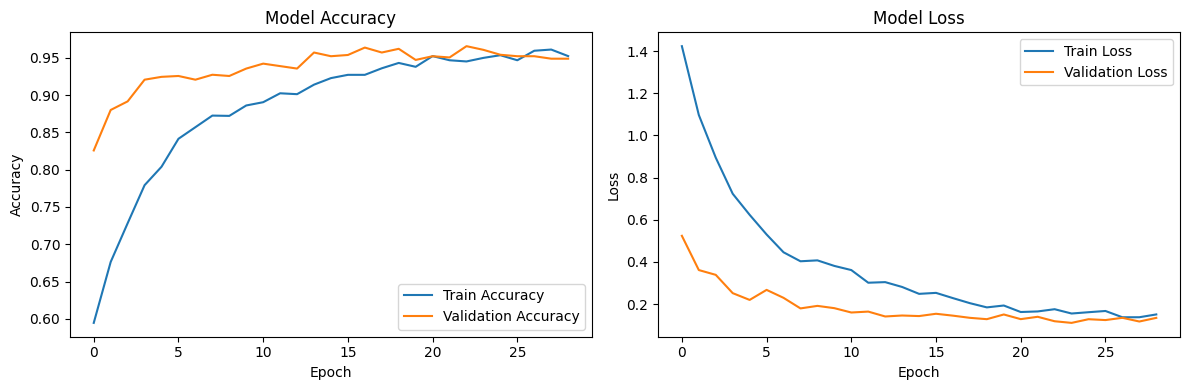

In [ ]:
# Plot Training History
def plot_history(history):
    # Plot training & validation accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_history(history)

In [ ]:
# Save Model and Label Encoder
model.save('/content/drive/MyDrive/Released_Data_NNDL_2025/dog_breed_classifier.h5')
import pickle
with open('/content/drive/MyDrive/Released_Data_NNDL_2025/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [ ]:
# Predict Breed
def predict_breed(img_path, model, label_encoder, target_size=(299, 299)):
    img = load_image(img_path, target_size)
    if img is None:
        return None
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)
    breed_idx = np.argmax(pred, axis=1)[0]
    subclass_index = label_encoder.inverse_transform([breed_idx])[0]

    return subclass_index

# Example usage
sample_img_path = os.path.join(data_path, train_df['image'].iloc[0])
predicted_subclass = predict_breed(sample_img_path, model, label_encoder)
print(f"Predicted subclass_index: {predicted_subclass}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted subclass_index: 2
